(45, 278)


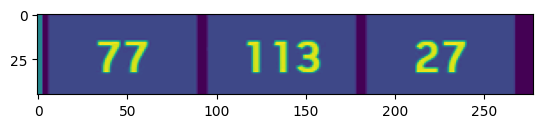

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


img_dir = os.path.join(os.getcwd(), "datasets", "images")
img1_path = os.path.join(img_dir, "img61.png")

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)

img1_shape = np.shape(img1)
print(img1_shape)
plt.imshow(img1)

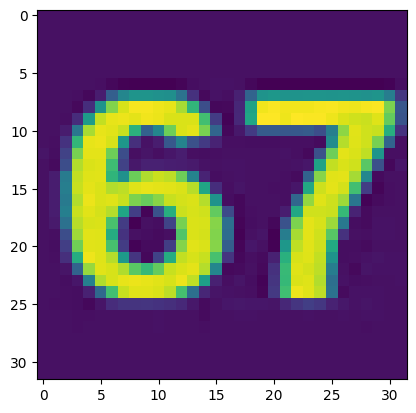

In [3]:
new_img1 = img1[:32, 30:62]
plt.imshow(new_img1)


In [13]:
def crop_image(img_path, n):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img[:32, 30:62]
    outdir = os.path.join(os.getcwd(), "new_images")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outfile = os.path.join(outdir, "image{}.png".format(n))
    cv2.imwrite(outfile, img)

def crop_img2d(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # img1 = img[:32, 30:46]
    # img2 = img[:32, 46:62]
    img1 = img[:44, 22:54]
    img2 = img[:44, 36:68]
    outdir = os.path.join(os.getcwd(), "newer_images")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outfile1 = os.path.join(outdir, "image12_1.png")
    outfile2 = os.path.join(outdir, "image20_0.png")
    cv2.imwrite(outfile1, img1)
    cv2.imwrite(outfile2, img2)

def crop_img3d(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img1 = img[:32, 24:34]
    img2 = img[:32, 34:52]
    img3 = img[:32, 52:68]
    outdir = os.path.join(os.getcwd(), "newer_images")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outfile1 = os.path.join(outdir, "image1_8.png")
    outfile2 = os.path.join(outdir, "image2_6.png")
    outfile3 = os.path.join(outdir, "image1_9.png")
    cv2.imwrite(outfile1, img1)
    cv2.imwrite(outfile2, img2)
    cv2.imwrite(outfile3, img3)

def crop_images(img_dir):
    i = 0
    for fname in os.listdir(img_dir):
        file_path = os.path.join(img_dir, fname)
        crop_image(file_path, i)
        i += 1

img_dir = os.path.join(os.getcwd(), "datasets", "newer_images")
img_path = os.path.join(img_dir, "image11.png")
crop_img2d(img_path)

In [14]:
p = r"C:\py_repos\image_classifier\newer_images\image21_0.png"
i = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
print(np.shape(i))

(44, 32)


In [15]:
import os
import cv2
import numpy as np


def zero_pad_img(img):
    if np.shape(img) == (32, 16):
        padded_img = np.pad(img, ((30, 30), (38, 38)), mode="constant", constant_values=0)
    elif np.shape(img) == (44, 92):
        padded_img = np.pad(img, ((24, 24), (0, 0)), mode='constant', constant_values=0)
    elif np.shape(img) == (44, 32):
        padded_img = np.pad(img, ((24, 24), (30, 30)), mode='constant', constant_values=0)
    elif np.shape(img) == (32, 10):
        padded_img = np.pad(img, ((30, 30), (41, 41)), mode='constant', constant_values=0)
    elif np.shape(img) == (32, 18):
        padded_img = np.pad(img, ((30, 30), (37, 37)), mode='constant', constant_values=0)
    elif np.shape(img) == (32, 12):
        padded_img = np.pad(img, ((30, 30), (40, 40)), mode='constant', constant_values=0)
    elif np.shape(img) == (38, 92):
        padded_img = np.pad(img, ((27, 27), (0, 0)), mode='constant', constant_values=0)
    else:
        raise ValueError("image has unexpexted shape: {}".format(np.shape(img)))
    assert np.shape(padded_img) == (92, 92), "check zero pad function"
    return padded_img

def pad_images():
    new_dir = os.path.join(os.getcwd(), "new_integer_images")
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)

    imgs_dir = os.path.join(os.getcwd(), "integer_image_dataset")
    for dirname in os.listdir(imgs_dir):
        subdir = os.path.join(imgs_dir, dirname)
        print(subdir)
        for fname in os.listdir(subdir):
            f = os.path.join(subdir, fname)
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            if np.shape(img) != (92, 92):
                img = zero_pad_img(img)
            save_path = os.path.join(new_dir, fname)
            cv2.imwrite(save_path, img)

def zero_pad_img_dir(img_dir):
    for fname in os.listdir(img_dir):
        f = os.path.join(img_dir, fname)
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if np.shape(img) != (92, 92):
            img = zero_pad_img(img)
            cv2.imwrite(f, img)

img_dir = os.path.join(os.getcwd(), "newer_images")
zero_pad_img_dir(img_dir)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_images():
    imgs_dir = os.path.join(os.getcwd(), "integer_image_dataset")
    outdir = os.path.join(os.getcwd(), "integer_images_dataset_small")
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for fname in os.listdir(imgs_dir):
        f = os.path.join(imgs_dir, fname)
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (38, 38))
        outfile = os.path.join(outdir, fname)
        cv2.imwrite(outfile, img)

imgs_dir = os.path.join(os.getcwd(), "digit_images_dataset")
print(len(os.listdir(imgs_dir)))

66


In [2]:
import tensorflow as tf
import os


saved_model_dir = os.path.join(os.getcwd(), "models", "saved_models")

model = tf.saved_model.load(saved_model_dir)
print(dir(model))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_checkpoint_dependencies', '_default_save_signature', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_gather_saveables_for_checkpoint', '_handle_deferred_dependencies', '_lookup_dependency', '_maybe_initialize_trackable', '_name_based_attribute_restore', '_name_based_restores', '_no_dependency', '_object_identifier', '_preload_simple_restoration', '_restore_from_tensors', '_self_name_based_restores', '_self_saveable_object_factories', '_self_setattr_tracking', '_self_unconditional_chec

In [2]:
import tensorflow as tf
import os


data_dir = os.path.join(os.getcwd(), "digit_images_dataset")



train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(92, 92),
  batch_size=32)



Found 70 files belonging to 10 classes.
Using 56 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(92, 92),
  batch_size=32)

Found 70 files belonging to 10 classes.
Using 14 files for validation.


In [20]:
def build_model(input_shape, n_outputs):
   model = tf.keras.models.Sequential()
   model.add(tf.keras.layers.Input((input_shape[0], input_shape[1], 3)))
   model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
   model.add(tf.keras.layers.MaxPool2D((2, 2)))
   model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
   model.add(tf.keras.layers.MaxPool2D((2, 2)))
   model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
   model.add(tf.keras.layers.Flatten())
   model.add(tf.keras.layers.Dense(128, activation="relu"))
   model.add(tf.keras.layers.Dense(n_outputs))
   model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=["accuracy"])
   return model

def convert_model_to_tflite(model):
  file_path = os.path.join(os.getcwd(), "models", "model.tflite")
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  with open(file_path, "wb") as fh:
    fh.write(tflite_model)

def save_tf_model(model):
  model_dir = os.path.join(os.getcwd(), "models")
  if not os.path.exists(model_dir):
      os.mkdir(model_dir)
  save_dir = os.path.join(model_dir, "saved_models")
  if not os.path.exists(save_dir):
      os.mkdir(save_dir)
  tf.saved_model.save(model, save_dir)

def convert_tflite_int8(saved_model_dir, input_shape=(92, 92), n_outputs=130):
  def representative_dataset():
    for _ in range(n_outputs):
      data = np.random.rand(1, input_shape[0], input_shape[1], 1)
      yield [data.astype(np.float32)]
      
  file_path = os.path.join(os.getcwd(), "models", "model.tflite")
  converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_quant_model = converter.convert()
  with open(file_path, "wb") as fh:
    fh.write(tflite_quant_model)

In [7]:
class_names = train_ds.class_names
class_names

['0_zero',
 '1_one',
 '2_two',
 '3_three',
 '4_four',
 '5_five',
 '6_six',
 '7_seven',
 '8_eight',
 '9_nine']

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

0.0 0.9843138
(92, 92, 3)


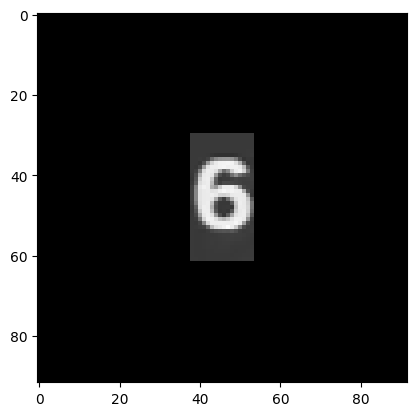

In [18]:
import numpy as np
import matplotlib.pyplot as plt

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(np.shape(first_image))
plt.imshow(first_image)

In [23]:
model = build_model((92, 92), 10)
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

print("Score Averages\n--------------------")
print(f"Accuracy: {np.average(acc)}")
print(f"Loss: {np.average(loss)}")
print(f"Val Accuracy: {np.average(val_acc)}")
print(f"Val Loss: {np.average(val_loss)}")
print("\nScores\n-------------------------")
print(f"Accuracy: {acc[-1]}")
print(f"Loss: {loss[-1]}")
print(f"Val Accuracy: {val_acc[-1]}")
print(f"Val Loss: {val_loss[-1]}")



Epoch 1/20
2/2 [==============================] - 1s 289ms/step - loss: 25.8146 - accuracy: 0.1250 - val_loss: 36.1073 - val_accuracy: 0.0714
Epoch 2/20
2/2 [==============================] - 0s 189ms/step - loss: 19.9031 - accuracy: 0.2679 - val_loss: 14.4437 - val_accuracy: 0.0000e+00
Epoch 3/20
2/2 [==============================] - 0s 187ms/step - loss: 7.7059 - accuracy: 0.3750 - val_loss: 5.1099 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 0s 182ms/step - loss: 3.0064 - accuracy: 0.4643 - val_loss: 2.4030 - val_accuracy: 0.2857
Epoch 5/20
2/2 [==============================] - 0s 152ms/step - loss: 1.6431 - accuracy: 0.5536 - val_loss: 2.0692 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 0s 179ms/step - loss: 1.4908 - accuracy: 0.5000 - val_loss: 1.6177 - val_accuracy: 0.4286
Epoch 7/20
2/2 [==============================] - 0s 176ms/step - loss: 0.9745 - accuracy: 0.7679 - val_loss: 1.0327 - val_accuracy: 0.9286
Epoch 8/20
2

In [24]:
digit_path = os.path.join(os.getcwd(), "digit_images_dataset", "5_five", "image5_0.png")

img = tf.keras.utils.load_img(digit_path, target_size=(92, 92))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 149ms/step
This image most likely belongs to 5_five with a 98.76 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))